In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

from dolfin import *

import sys
sys.path.insert(0, '../../')
import reaktoro_transport.solver as solver
import reaktoro_transport.tools as tools

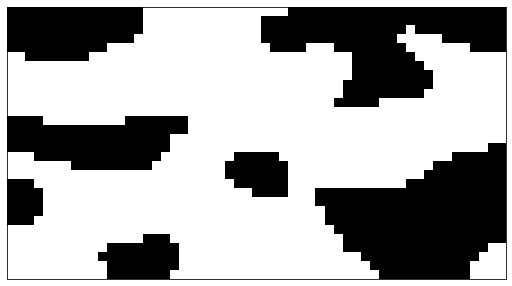

In [2]:
# This is an example of mesh creation using pore image by Reaktoro_Transport.
# Import an image created by porespy. See http://porespy.org/
im = np.load('pore_image.npy')

plt.figure(figsize=(10,5))
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.imshow(im, origin='lower', cmap='binary') # Let's say 0 represents fluid and 1 respresents solid
#plt.colorbar()
#plt.axis('off')
plt.show()

In [3]:
# Create a grid interpolator using scipy
nx, ny = np.shape(im.T)
print(nx, ny)

print(np.sum(im)/nx/ny)

# We normalized the length in both x and y direction. 
# The units of length should correspond the units you use for simulations.
xmin = 0.0
xmax = 18.33
ymin = 0.0
ymax = 10.0
x_space = np.linspace(xmin, xmax, nx)
y_space = np.linspace(ymin, ymax, ny)

#x_space = np.delete(x_space, [1, nx])
#y_space = np.delete(y_space, [1, ny])

xx, yy = np.meshgrid(x_space, y_space)

imT = np.flip(np.rot90(im), axis=0)
#imT = np.flip(im, axis=0)

f_of_phi_cg = RegularGridInterpolator((x_space, y_space), imT, 'linear', bounds_error=False)
f_of_phi_dg = RegularGridInterpolator((x_space, y_space), imT, 'nearest', bounds_error=True)

55 30
0.37393939393939396


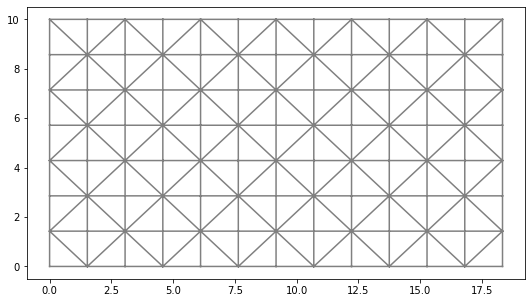

In [4]:
# Generate a rectangle mesh using dolfin/fenics
mesh_2d = RectangleMesh.create([Point(xmin, ymin), Point(xmax, ymax)], [12, 7], CellType.Type.triangle, 'right/left')

plt.figure(figsize=(10,5))
plot(mesh_2d)
plt.show()

Used  3 iterations. Mesh generation successful!
Vertices count:  4373


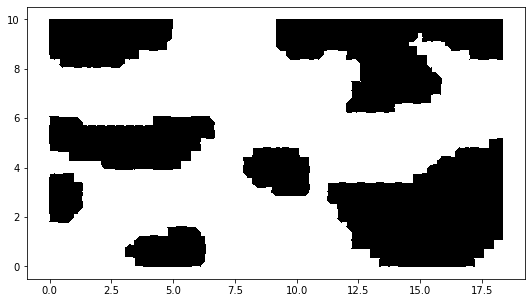

CPU times: user 766 ms, sys: 470 ms, total: 1.24 s
Wall time: 581 ms


In [5]:
%%time

mesh_2d, phi_DG = tools.refine_mesh_dg(mesh_2d, f_of_phi_dg, min_cell_size=4e-1, where='bf')

print('Vertices count: ', mesh_2d.num_vertices())

phi_DG_filtered = phi_DG.copy()

# Apply filter to phi_DG
for i, phi_val in enumerate(phi_DG.vector()[:]):
    if phi_val > 0.01:
        phi_DG_filtered.vector()[i] = 1 # True
    else:
        phi_DG_filtered.vector()[i] = 0

plt.figure(figsize=(10,5))
plot(phi_DG_filtered, cmap='binary')
#plot(mesh_2d)
plt.show()

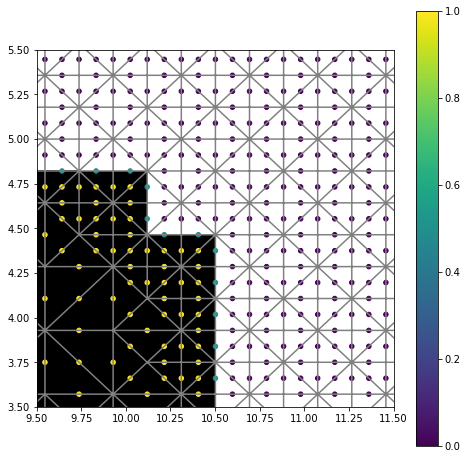

In [6]:
# Create a CR function that stores the fluid/solid boundaries
CR_space = FunctionSpace(mesh_2d, 'CR', 1)
cr_dof = CR_space.dofmap().dofs(mesh_2d, 1)

phi_CR = project(phi_DG, CR_space)

dof_coordinates_cr = CR_space.tabulate_dof_coordinates()
dof_x_cr = dof_coordinates_cr[:, 0]                                                    
dof_y_cr = dof_coordinates_cr[:, 1]

# We see that the fluid and solid boundaries are clearly marked as 0.5
plt.figure(figsize=(8,8))
plot(mesh_2d)
plot(phi_DG_filtered, cmap='binary')
plt.scatter(dof_x_cr, dof_y_cr, c=phi_CR.vector()[:], s = 20)
plt.colorbar()
plt.xlim(9.5, 11.5)
plt.ylim(3.5, 5.5)
plt.show()

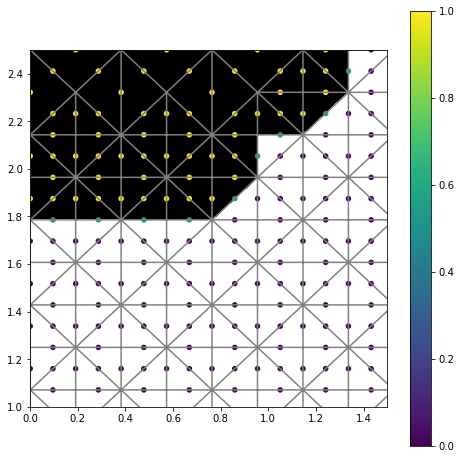

In [7]:
# The fluid and solid domain on mesh boundaries are marked correctly
plt.figure(figsize=(8,8))
plot(mesh_2d)
plot(phi_DG, cmap='binary')
plt.scatter(dof_x_cr, dof_y_cr, c=phi_CR.vector()[:], s = 20)
plt.colorbar()
plt.xlim(0., 1.5)
plt.ylim(1.0, 2.5)
plt.show()

In [8]:
# Create cell_markers and boundary_markers MeshFunction
cell_markers = MeshFunction('size_t', mesh_2d, dim=2)
boundary_markers = MeshFunction('size_t', mesh_2d, dim=1)

cell_markers.array()[:] = phi_DG_filtered.vector()[:]


# In addition to marking solid, fluid and the solid/fluid boundaries,
# we can still use fenics/dolfin functions to mark the obvious boundaries.
# For example, we want to apply a pressure boundary on the left boundary:

class left(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0, DOLFIN_EPS)
    
class right(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 18.33, DOLFIN_EPS)
    
class top_bottom(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[1], 0.0, DOLFIN_EPS) or near(x[1], 10.0, DOLFIN_EPS))
    
b_left = left()
b_right = right()
b_noslip = top_bottom()

# Boundary on the fluid domain is marked as 0
boundary_markers.set_all(0)

# Then Mark boundaries
b_left.mark(boundary_markers, 2)
b_right.mark(boundary_markers, 3)

# Find the solid, fluid, s/f boundary indices
index_solid = phi_CR.vector()[cr_dof] > 0.999
#index_fluid = phi_CR.vector()[cr_dof] < 0.01
index_sf_boundary = np.logical_and(phi_CR.vector()[cr_dof] <= 0.999, phi_CR.vector()[cr_dof] >= 0.001)

# Mark them
boundary_markers.array()[index_solid] = 1
#boundary_markers.array()[index_fluid] = 0
boundary_markers.array()[index_sf_boundary] = 4

# Mark the noslip boundaries at the end
b_noslip.mark(boundary_markers, 5)

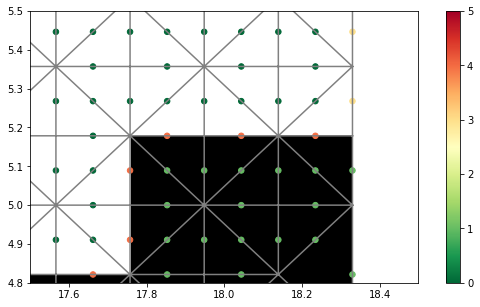

In [9]:
# Check if they are correctly marked.
plt.figure(figsize=(10,5))
plot(mesh_2d)
plot(phi_DG, cmap='binary')
plt.scatter(dof_x_cr[cr_dof], dof_y_cr[cr_dof], c=boundary_markers.array(), s=30, cmap='RdYlGn_r')
plt.colorbar()
plt.xlim(17.5, 18.5)
plt.ylim(4.8, 5.5)
plt.show()

In [10]:
# Save them as xdmf for simulations!
xdmf_obj = XDMFFile(MPI.comm_world, '../2_flow_simulation/mesh.xdmf')
xdmf_obj.write(mesh_2d)
xdmf_obj.write(cell_markers)
xdmf_obj.close()

xdmf_obj = XDMFFile(MPI.comm_world, '../2_flow_simulation/boundary.xdmf')
xdmf_obj.write(boundary_markers)
xdmf_obj.close()

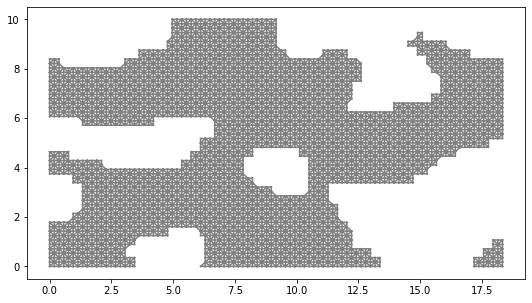

In [11]:
# Generate mesh without solid domain
sub_mesh = SubMesh(mesh_2d, cell_markers, 0)

plt.figure(figsize=(10,5))
plot(sub_mesh)
plt.show()

In [12]:
# Create boundary_markers MeshFunction
boundary_markers = MeshFunction('size_t', sub_mesh, dim=1)

# In this submesh that contains only the fluid domain, 
# we can still use fenics/dolfin functions to mark the obvious boundaries.
# For example, we want to apply a pressure boundary on the left boundary:

class top_left(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0, DOLFIN_EPS) and (x[1]>=5.5)
    
class bottom_left(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0, DOLFIN_EPS) and (x[1]<5.5)
    
class right(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 18.33, DOLFIN_EPS)
    
class all_boundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary

b_top_left = top_left()
b_bottom_left = bottom_left()
b_right = right()
all_bound = all_boundary()

# Boundaries in the fluid domain is marked as 0
boundary_markers.set_all(0)

# Mark all boundaries (solid-fluid interfaces)
all_bound.mark(boundary_markers, 10)

# Then Mark boundaries
b_top_left.mark(boundary_markers, 2)
b_bottom_left.mark(boundary_markers, 3)
b_right.mark(boundary_markers, 4)

In [13]:
cell_markers = MeshFunction('size_t', sub_mesh, dim=2)
cell_markers.set_all(0)

In [14]:
# Save them as xdmf for simulations!
xdmf_obj = XDMFFile(MPI.comm_world, '../2_flow_simulation/fluid_mesh.xdmf')
xdmf_obj.write(sub_mesh)
xdmf_obj.write(cell_markers)
xdmf_obj.close()

xdmf_obj = XDMFFile(MPI.comm_world, '../2_flow_simulation/fluid_boundary.xdmf')
xdmf_obj.write(boundary_markers)
xdmf_obj.close()